In [1]:
# Klusta sort for comparing sorting
!pip install Cython h5py tqdm
!pip install click klusta klustakwik2

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np 
import spikeinterface.comparison as sc
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.toolkit as st
import spikeinterface.widgets as sw
import scipy.io
import h5py
import hdf5storage
import time
import os
from sklearn import preprocessing 

20:46:29 [I] klustakwik KlustaKwik2 version 0.2.6


In [12]:
#This path is for PG's personal computer
f = h5py.File('../eisi_raw_mat_files/acc_1_04072016_kurosawacoppola_pre.mat', 'r')

start_time = time.time()
num_channels = f['mat'].shape[1]
ts = np.transpose(np.array(f['mat']))
f.close()

sampling_frequency = 40000  # in Hz
geom = np.zeros((num_channels, 2))
geom[:, 0] = range(num_channels)
recording = se.NumpyRecordingExtractor(timeseries=ts, geom=geom, sampling_frequency=sampling_frequency)
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. timepoints = {}'.format(recording.get_num_frames()))

print("Extraction time:", time.time() - start_time)

Num. channels = 1
Sampling frequency = 40000.0 Hz
Num. timepoints = 55069237
Extraction time: 1.3495640754699707


In [83]:
help(se.NumpyRecordingExtractor)

/Users/beam/opt/anaconda3/lib/python3.8/inspect.py:457: ResourceWarning: unclosed file <_io.FileIO name=102 mode='rb' closefd=True>
  if name in base.__dict__:
Exception ignored in: <function BaseExtractor.__del__ at 0x7fdc3a8a9af0>
Traceback (most recent call last):
  File "/Users/beam/opt/anaconda3/lib/python3.8/site-packages/spikeextractors/baseextractor.py", line 35, in __del__
    for memmap_file in self._memmap_files:
AttributeError: 'MdaRecordingExtractor' object has no attribute '_memmap_files'


Help on class NumpyRecordingExtractor in module spikeextractors.extractors.numpyextractors.numpyextractors:

class NumpyRecordingExtractor(spikeextractors.recordingextractor.RecordingExtractor)
 |  NumpyRecordingExtractor(timeseries, sampling_frequency, geom=None)
 |  
 |  A class that contains functions for extracting important information
 |  from recorded extracellular data. It is an abstract class so all
 |  functions with the @abstractmethod tag must be implemented for the
 |  initialization to work.
 |  
 |  Method resolution order:
 |      NumpyRecordingExtractor
 |      spikeextractors.recordingextractor.RecordingExtractor
 |      abc.ABC
 |      spikeextractors.baseextractor.BaseExtractor
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, timeseries, sampling_frequency, geom=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_channel_ids(self)
 |      Returns the list of channel ids. If not specified, the range 

In [17]:
def plot_metric(data, bins, x_axis_label, color, max_value=-1):
    
    h, b = np.histogram(data, bins=bins, density=True)

    x = b[:-1]
    y = gaussian_filter1d(h, 1)

    plt.plot(x, y, color=color)
    plt.xlabel(x_axis_label)
#     plt.gca().get_yaxis().set_visible(False)
#     [plt.gca().spines[loc].set_visible(False) for loc in ['right', 'top', 'left']]
#     if max_value < np.max(y) * 1.1:
#         max_value = np.max(y) * 1.1
#     plt.ylim([0, max_value])
    
    return max_value

In [18]:
from scipy.ndimage.filters import gaussian_filter1d
# bins = np.linspace(0,100,100)
# data = snip
# snip = recording.get_traces()
data = np.log10(snip)
bins = np.linspace(-3,2,100)
max_value = plot_metric(data, bins, 'Firing rate (Hz)', 'red')

# plot_metric(snip, np.linspace(0,100,100), 'Firing rate (Hz)', 'blue')


NameError: name 'snip' is not defined

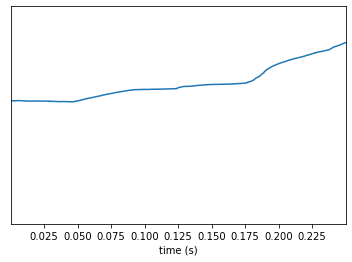

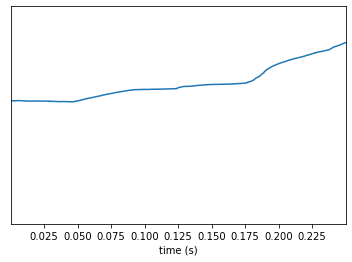

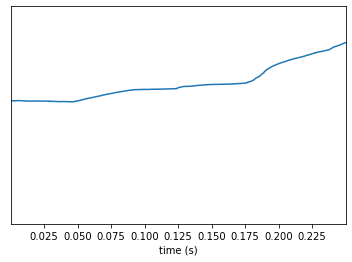

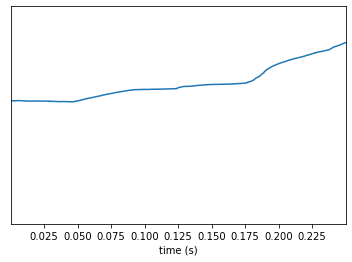

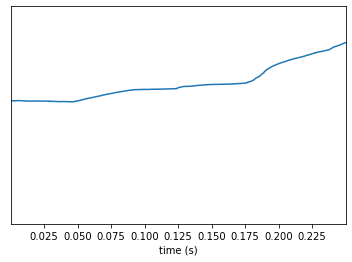

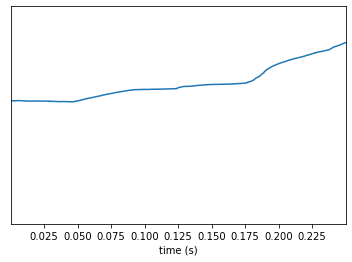

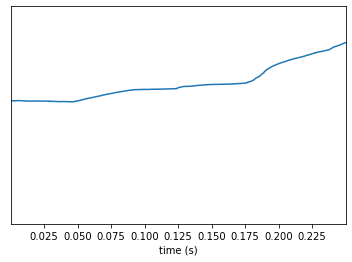

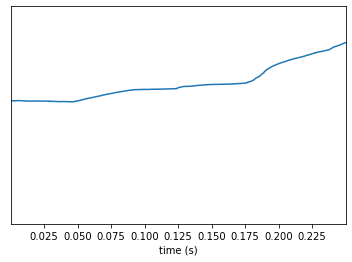

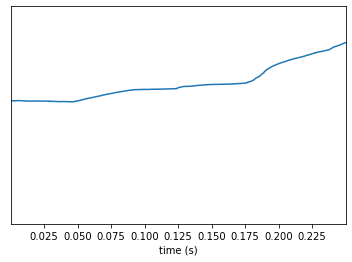

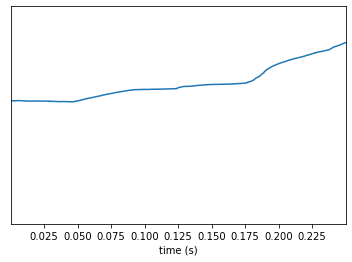

In [77]:
frames = recording.get_num_frames()
frame_slot = frames/10
for i in range(10):
    recording.add_epoch(epoch_name='stimulation', start_frame= i*frame_slot, end_frame = (i+1)*frame_slot)
    recording2 = recording.get_epoch(epoch_name='stimulation')
    w_ts = sw.plot_timeseries(recording)
# w_ts.figure.suptitle("Recording by group")

In [13]:
start_time = time.time()

recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)

print("Pre-processing time:", time.time() - start_time)

Pre-processing time: 0.032605886459350586


In [4]:
help(ss.run_mountainsort4)

Help on function run_mountainsort4 in module spikesorters.sorterlist:

run_mountainsort4(*args, **kwargs)
    Runs mountainsort4 sorter
    
    Parameters
    ----------
    *args: arguments of 'run_sorter'
        recording: RecordingExtractor
            The recording extractor to be spike sorted
        output_folder: str or Path
            Path to output folder
        delete_output_folder: bool
            If True, output folder is deleted (default False)
        grouping_property: str
            Splits spike sorting by 'grouping_property' (e.g. 'groups')
        parallel: bool
            If True and spike sorting is by 'grouping_property', spike sorting jobs are launched in parallel
        verbose: bool
            If True, output is verbose
        raise_error: bool
            If True, an error is raised if spike sorting fails (default). If False, the process continues and the error 
            is logged in the log file
        n_jobs: int
            Number of jobs when 

In [14]:
default_ms4_params = ss.Mountainsort4Sorter.default_params()
default_ms4_params['detect_threshold'] = 4
default_ms4_params['curation'] = False
# set filter to false if pre_processing done on recording and recording=recording_f
default_ms4_params['filter'] = False 
file_name = 'acc_1_04052016_kurocoppola_pre'
sorting = ss.run_mountainsort4(recording=recording_f, **default_ms4_params, output_folder='../'+file_name, verbose=True)

Using 4 workers.
Using tmpdir: /tmp/tmp26s3hvw7
Num. workers = 4
Preparing /tmp/tmp26s3hvw7/timeseries.hdf5...
'end_frame' set to 55069237
Preparing neighborhood sorters (M=1, N=55069237)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp26s3hvw7
mountainsort4 run time 16.77s


In [15]:
start_time = time.time()
wf = st.postprocessing.get_unit_waveforms(recording, sorting, ms_before=1, ms_after=2,
                                          save_as_features=True, verbose=True)
print("Shared unit spike feature names: ", sorting.get_shared_unit_spike_feature_names())
print("Number of waveforms extracted: ", len(wf))
print("Waveforms (n_spikes, n_channels, n_points)", wf[0].shape)

max_chan = st.postprocessing.get_unit_max_channels(recording, sorting, save_as_property=True, verbose=True)
# savename = 'average_waveform/'+file_name+'_avg_waveforms.mat'
# scipy.io.savemat(savename,{'wf':wf,'maxchn':max_chan}, do_compression=True)

Waveform 1/6
Waveform 2/6
Waveform 3/6
Waveform 4/6
Waveform 5/6
Waveform 6/6
Shared unit spike feature names:  ['waveforms', 'waveforms_idxs']
Number of waveforms extracted:  6
Waveforms (n_spikes, n_channels, n_points) (300, 1, 120)


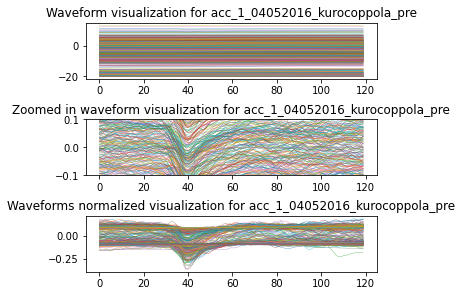

In [16]:
# Plotting the transpose wf[0][:, 0, :].T meaning for first channel, first unit
fig, axs = plt.subplots(3, 1, constrained_layout=True)

for i in range(len(wf)): # For all units with first channel
    axs[0].plot(wf[i][:, 0, :].T, lw=0.3)
    axs[1].plot(wf[i][:, 0, :].T, lw=0.3)
    normalized = preprocessing.normalize(wf[i][:,0,:])
    axs[2].plot(normalized.T, lw=0.3)

axs[1].set_ylim(-0.1, 0.1) # Zoom in to show wave like feature and same scale as unit templates
axs[0].set_title('Waveform visualization for '+ file_name)
axs[1].set_title('Zoomed in waveform visualization for '+ file_name)
axs[2].set_title('Waveforms normalized visualization for '+ file_name)
plt.show()

(6, 1, 120)
Postprocessing time:  1747.8868551254272


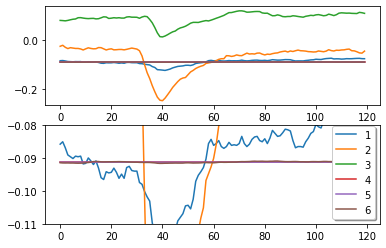

In [30]:
templates = st.postprocessing.get_unit_templates(recording, sorting, max_spikes_per_unit=200,
                                                 save_as_property=True, verbose=True)

print(np.shape(templates))

fig, ax = plt.subplots(2,1)
unit_num = len(wf)
for i in range(unit_num):
#     ax.plot(templates[i].T)
    normalized = preprocessing.normalize(np.array(templates)[i][:,:])
    ax[0].plot(normalized.T, label=i+1)
    ax[1].plot(normalized.T, label=i+1)

legend = ax[1].legend(loc='lower right', shadow=True)
ax[1].set_ylim(-0.11, -0.08)

print("Postprocessing time: ", time.time() - start_time)

In [31]:
fig.savefig(file_name + '_template.png')

In [18]:
# compute_unit_pca_scores(recording, sorting, unit_ids=None, channel_ids=None, return_idxs=False, _waveforms=None, _spike_index_list=None, _channel_index_list=None, **kwargs)
# n_comp: int Number of PCA components (default 3)
pca_scores = st.postprocessing.compute_unit_pca_scores(recording, sorting, n_comp=3, by_electode= True, verbose=True)

Computing waveforms
Fitting PCA of 3 dimensions on 1505 waveforms
Projecting waveforms on PC


In [84]:
help(st.postprocessing.compute_unit_pca_scores)

Help on function compute_unit_pca_scores in module spiketoolkit.postprocessing.postprocessing_tools:

compute_unit_pca_scores(recording, sorting, unit_ids=None, channel_ids=None, return_idxs=False, _waveforms=None, _spike_index_list=None, _channel_index_list=None, **kwargs)
    Computes the PCA scores from the unit waveforms. If waveforms are not found as features, they are computed.
    
    Parameters
    ----------
    recording: RecordingExtractor
        The recording extractor
    sorting: SortingExtractor
        The sorting extractor
    unit_ids: list
        List of unit ids to compute pca scores
    channel_ids: list
        List of channels ids to compute pca from
    return_idxs: list
        List of indexes of used spikes for each unit
    _waveforms: list
        Pre-computed waveforms (optional)
    _spike_index_list: list
        Pre-computed spike indexes for waveforms (optional)
    _channel_index_list: list
        Pre-computed channel indexes for waveforms (optiona

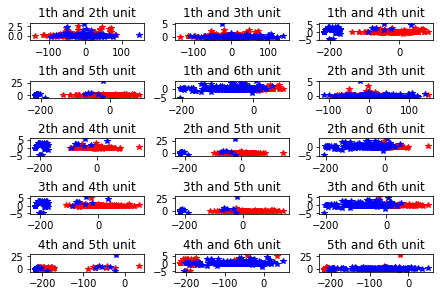

In [35]:
pca_scores = st.postprocessing.compute_unit_pca_scores(recording, sorting, n_comp=2, verbose=True)

# for pc in pca_scores:
#     print(pc.shape)

# fig, ax = plt.subplots()
# ax.plot(pca_scores[0][:, 0, 0], pca_scores[0][:, 0, 1], 'r*')
# ax.plot(pca_scores[5][:, 0, 0], pca_scores[5][:, 0, 1], 'b*')

fig, axs = plt.subplots(5, 3, constrained_layout=True)
# color = ['r*', 'b*', 'y*']
i = 0
for j in range(len(wf)):
    for k in range(j +1, len(wf)):
        axs[i//3, i%3].set_title('{}th and {}th unit'.format(j + 1, k + 1))
        axs[i//3, i%3].plot(pca_scores[j][:, 0, 0], pca_scores[j][:, 0, 1], 'r*')
        axs[i//3, i%3].plot(pca_scores[k][:, 0, 0], pca_scores[k][:, 0, 1], 'b*')
        i += 1
fig.savefig(file_name + '_visualization.png')

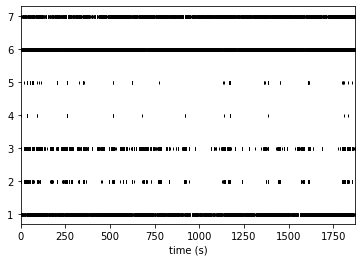

In [51]:
w_rs = sw.plot_rasters(sorting)

In [32]:
help(sw.plot_crosscorrelograms)

Help on function plot_crosscorrelograms in module spikewidgets.widgets.correlogramswidget.correlogramswidget:

plot_crosscorrelograms(sorting, sampling_frequency=None, unit_ids=None, bin_size=1, window=10, figure=None, ax=None, axes=None)
    Plots spike train cross-correlograms.
    
    Parameters
    ----------
    sorting: SortingExtractor
        The sorting extractor object
    sampling_frequency: float
        The sampling frequency (if not in the sorting extractor)
    unit_ids: list
        List of unit ids
    bin_size: float
        Bin size in s
    window: float
        Window size in s
    figure: matplotlib figure
        The figure to be used. If not given a figure is created
    ax: matplotlib axis
        The axis to be used. If not given an axis is created
    axes: list of matplotlib axes
        The axes to be used for the individual plots. If not given the required axes are created. If provided, the ax
        and figure parameters are ignored
    
    Returns
   

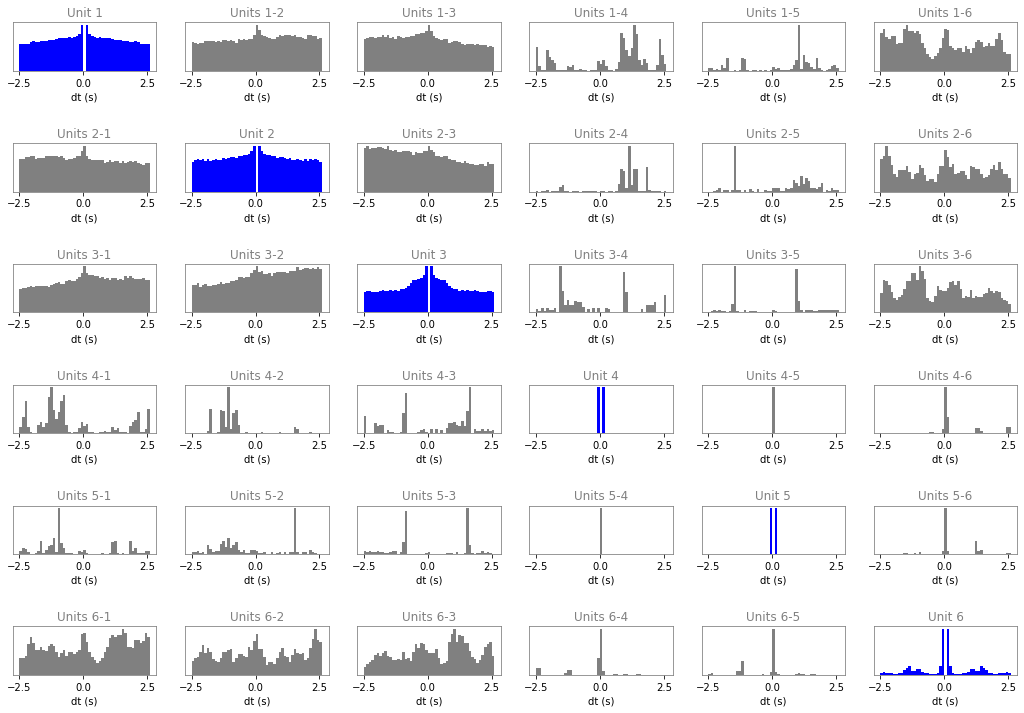

In [33]:
fig = plt.figure()
w_cch = sw.plot_crosscorrelograms(sorting, figure=fig, bin_size=0.1, window=5)

In [34]:
fig.savefig(file_name + '_crosscorrelogram.png')

## Quality Metrics for Validation of Sorted Data

https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html

### Firing Rate

- If a unit is poorly isolated, the firing rate will be over-estimated, because contaminating spikes will be included in the calculation
- If a unit's amplitude is close to threshold, the firing rate will be under-estimated, because some spikes will be missing
- If a unit drifts out of the recording, the firing rate will be under-estimated, because spikes will not be detected for a portion of the recording
- If data acquisition is interrupted (true for a small subset of experiments), the firing rate will be under-estimated, because spikes will be missing from gaps in the recording

**How it should be used**

- Firing rate can be used to filter out units that have too few spikes to result in meaningful analysis. In this case, it may be better to use the firing rate for the specific interval you're analyzing, because some units may drift out of the recording at other times.
- High firing rate units tend to be easier to isolate, since there are more spikes available for fitting the template in Kilosort2. However, there are other metrics that measure isolation more directly and would likely to be better to use instead.

### Presence Ratio

- It measures the fraction of time during a session in which a unit is spiking, and ranges from 0 to 0.99 (an off-by-one error in the calculation ensures that it will never reach 1.0). It's clear that most units have a presence ratio of 0.9 or higher, which means they are present for at least 90% of the recording. Units with lower presence ratio are likely to have drifted out of the recording, or had waveforms that changed so dramatically they were assigend to separate clusters.

**How it can be biased**

- Just because a unit has a high presence ratio doesn't mean it's immune to drift. If a unit's amplitude drifts closer to the spike detection threshold, it can result in dramatic changes in apparent firing rate, even if the underlying physiology remains the same.
- Sometimes a low presence ratio can result from highly selective spiking patterns (e.g., firing only during running epochs)

**How it should be used**

- If you are analyzing changes in firing rate over the entire recording session, or are comparing responses to stimuli presented at the beginning and end of the experiment, presence ratio is a simple way to exclude units that would bias your results. However, you should also look at other quality metrics, such as amplitude cutoff, to check for more subtle effects of electrode drift.
- If you are only analyzing a short segment of the experiment, it may be helpful to disable the default presence ratio filter, in order to maximize the number of units available to you.
- If you're unsure whether a unit has a low presence ratio due to electrode drift or selective firing, plotting its spike amplitudes over time can be informative.

### Amplitude cutoff

Amplitude cutoff provides another way to check for units that are missing spikes. Unlike presence ratio, which detects units that drift out of the recording, amplitude cutoff provides an estimate of the false negative rate—e.g., the fraction of spikes below the spike detection threshold. Thus, amplitude cutoff is a measure of unit "completeness" that is complementary to presence ratio.

**How it can be biasedv

- The calculation assumes that the amplitude histogram is symmetrical (i.e., it uses the upper tail of the distribution to estimate the fraction of spikes missing from the lower tail). If a unit's waveform amplitude changes as a result of electrode drift, this assumption is usually invalid.
- Amplitude cutoff is only weakly correlated with other measures of unit quality, meaning it's possible to have well-isolated units with high amplitude cutoff.

**How it should be used**

- If you are performing analyses that depends on precise measurements of spike timing, setting a low amplitude cutoff threshold (0.01 or lower) is recommended. This will remove a large fraction of units, but will ensure that the unit of interest contain most of the relevant spikes.

### ISI violations

- Inter-spike-interval (ISI) violations are a classic measure of unit contamination. Because all neurons have a biophysical refractory period, we can assume that any spikes occurring in rapid succession (<1.5 ms intervals) come from two different neurons. Therefore, the more a unit is contaminated by spikes from multiple neurons, the higher its isi_violations value will be.
- The calculation for ISI violations comes from Hill et al. (2011) J Neurosci 31: 8699-8705. Rather than reporting the fraction of spikes with ISI violations, their metric reports the relative firing rate of the hypothetical neurons that are generating these violations. You can interpret an ISI violations value of 0.5 as meaning that contamining spikes are occurring at roughly half the rate of "true" spikes for that unit. In cases of highly contaminated units, the ISI violations value can sometimes be even greater than 1.

**How it can be biased**

- As with all metrics, ISI violations may not be stable throughout the experiment. It may be helpful to re-calculate it for the specific epochs you're analyzing.
- Two neurons with similar waveforms, but firing in largely non-overlapping epochs, could end up being merged into the same cluster. In this case, the ISI violations may be low, even though the resulting unit is a highly contaminated. This situation would tricky to catch, but fortunately shouldn't happen very often.

**How it should be used**

- Setting your ISI violations threshold to 0 (or close to it), will help ensure that contaminated units don't make it into your analysis, but will greatly reduce the number of units available. You should think carefully about what degree of contamination your analysis can tolerate without biasing your conclusions. For example, if you are comparing firing rates of individual units across areas, you'll want to set a low ISI violations threshold to prevent contaminating spikes from affecting your estimates. On the other hand, if you're comparing overall firing rates between areas, counting spikes from contaminated clusters may be valid.

### SNR

- Signal-to-noise ratio, or SNR, is another classic metric of unit quality. It measures the ratio of the maximum amplitude of the mean spike waveform to the standard deviation of the background noise on one channel. Even though it's widely used in the literature, we don't recommend using it on Neuropixels data for two reasons:

- It only takes into account the unit's peak channel, despite the fact that waveforms are often spread across a dozen channels or more.
- If the waveform changes due to drift, peak channel SNR can change dramatically, even though overall isolation quality remains consistent.

**How it can be biased**

- SNR only considers information contained in a single channel, and therefore cannot capture isolation quality accurately
- If the peak channel moves across the probe due to electrode drift, SNR will drop.

**How it should be used**

- SNR can be helpful as a point of comparison to the previous literature
- It should not be used to filter data in isolation


### NN Hit Rate

- Nearest-neighbors hit rate is another PC-based quality metric. It's derived from the 'isolation' metric originally reported in Chung, Magland et al. (2017). This metric looks at the PCs for one unit and calculates the fraction of their nearest neighbors that fall within the same cluster. If a unit is highly contaminated, then many of the closest spikes will come from other units. Nearest-neighbors hit rate is nice because it always falls between 0 and 1, making it straightforward to compare across different datasets.

**How it can be biased**

- Like the other PC-based metrics, nn_hit_rate can be negatively impacted by electrode drift.

**How it should be used**

- nn_hit_rate is a nice proxy for overall cluster quality, but should be used in conjunction with other metrics that measure missing spikes or contamination rate more directly.

**Not included: isolation distance, d-prime**

In [36]:
metrics = st.validation.compute_quality_metrics(sorting=sorting, recording=recording,
                                                metric_names=['firing_rate', 'isi_violation', 'snr', 'nn_hit_rate', 'nn_miss_rate'],
                                                as_dataframe=True)
print("Metrics full recording")
print(metrics)

Metrics full recording
   firing_rate  isi_violation          snr  nn_hit_rate  nn_miss_rate
1     4.645788       0.803163    34.800213     0.268889      0.179806
2     2.335242       0.044771    24.259277     0.375556      0.162656
3     2.004023       0.486350    16.290533     0.346667      0.175104
4     0.165610    1789.321834  3263.352051     0.785088      0.032106
5     0.055930    4605.032071  3263.654541     0.519481      0.024276
6     3.636876      47.956343  1023.025330     0.618889      0.086030


In [83]:
help(st.validation.compute_quality_metrics)

Help on function compute_quality_metrics in module spiketoolkit.validation.quality_metrics:

compute_quality_metrics(sorting, recording=None, duration_in_frames=None, sampling_frequency=None, metric_names=None, unit_ids=None, as_dataframe=False, isi_threshold=0.0015, min_isi=None, snr_mode='mad', snr_noise_duration=10.0, max_spikes_per_unit_for_snr=1000, template_mode='median', max_channel_peak='both', drift_metrics_interval_s=51, drift_metrics_min_spikes_per_interval=10, max_spikes_for_silhouette=10000, num_channels_to_compare=13, max_spikes_per_cluster=500, max_spikes_for_nn=10000, n_neighbors=4, **kwargs)
    Computes and returns all specified metrics for the sorted dataset.
    
    Parameters
    ----------
    sorting: SortingExtractor
        The sorting result to be evaluated.
    recording: RecordingExtractor
        The given recording extractor from which to extract amplitudes
    duration_in_frames: int
        Length of recording (in frames).
    sampling_frequency: float
